Import Data from File and Calculate $\Delta$F/F

In [1]:
import numpy as np
from wfield import load_stack

# Load raw data
raw_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'
raw_file = 'ctb09_spontaneous_dark_run000_00000000_1_512_512_uint16.dat'
raw = load_stack(raw_path + raw_file)

# Grab reference frame for plotting
ref_frame = raw[1].squeeze().astype('float')

# Generate deltaF/F matrix
F = np.percentile(raw.squeeze(), 20, axis=0)
dFF = (raw.squeeze() - F)

Set Mask to Fit Cranial Window

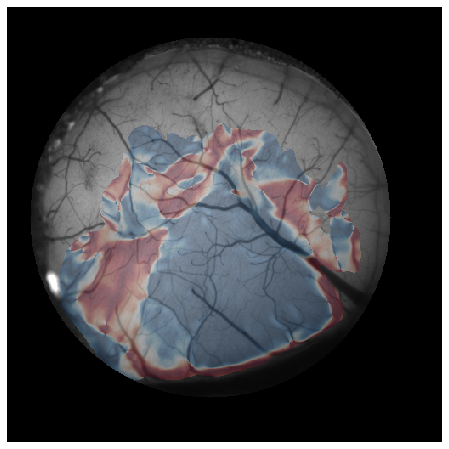

In [2]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

# Define crosshair cursor (from matplotlib documentation)
class Cursor:

    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()

# Plot reference frame and get user input for center and edge points of circular mask
%matplotlib qt5
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.axis('off')
ax.set_title('Select Center Point and Edge Point for Circular Mask:', fontsize=20, color='k')
fig.set_size_inches(10, 10)
cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)
mask_coors = plt.ginput(n=2, timeout=-1)
plt.close('all')

# Generate mask and get indices to set as nan
import cv2
mask = np.zeros(ref_frame.shape, dtype=np.uint8)
radius = np.linalg.norm(np.array(mask_coors[1]) - np.array(mask_coors[0]))
circle = cv2.circle(mask, (int(mask_coors[0][0]),int(mask_coors[0][1])), int(radius), (255,255,255), -1).astype('float')
circle[circle == 255] = np.nan
mask_idx = (tuple(np.where(mask == 0)[0]), tuple(np.where(mask == 0)[1]))

# Load sign map
signmap_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
signmap_file = 'signmap.csv'
signmap = np.loadtxt(signmap_path + signmap_file)

# Plot reference frame and sign map to check mask placement
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.imshow(circle, cmap='gray', alpha=1)
ax.axis('off')
fig.set_size_inches(8, 8)

Mask Reference Frame & $\Delta$F/F Matrix

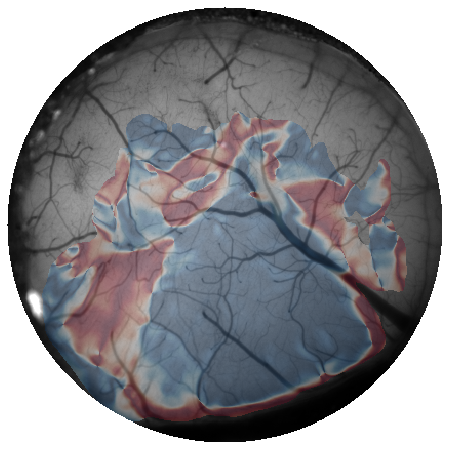

In [3]:
# Set pixel window size for correlation map
window_size = 2

# Mask reference frame and remove edges with all nan, accounting for pixel window size
np.add.at(ref_frame, mask_idx, np.nan)
row_mask = np.where(~np.isnan(ref_frame).all(axis=1))[0]
row_mask = row_mask[range(window_size * np.floor_divide(row_mask.shape[0], window_size))]
col_mask = np.where(~np.isnan(ref_frame).all(axis=0))[0]
col_mask = col_mask[range(window_size * np.floor_divide(col_mask.shape[0], window_size))]
edge_mask = np.ix_(row_mask, col_mask)
ref_frame = ref_frame[edge_mask]

# Mask sign map
np.add.at(signmap, mask_idx, np.nan)
signmap = signmap[edge_mask]

# Plot masked reference frame and sign map
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.axis('off')
fig.set_size_inches(8, 8)

# Mask deltaF/F matrix
dFF_masked = []
for frame in dFF:
     np.add.at(frame, mask_idx, np.nan)
     dFF_masked.append(frame[edge_mask])
dFF_masked = np.asarray(dFF_masked)

Get Visual Area Boundaries from Sign Map for Plotting against SCA Maps

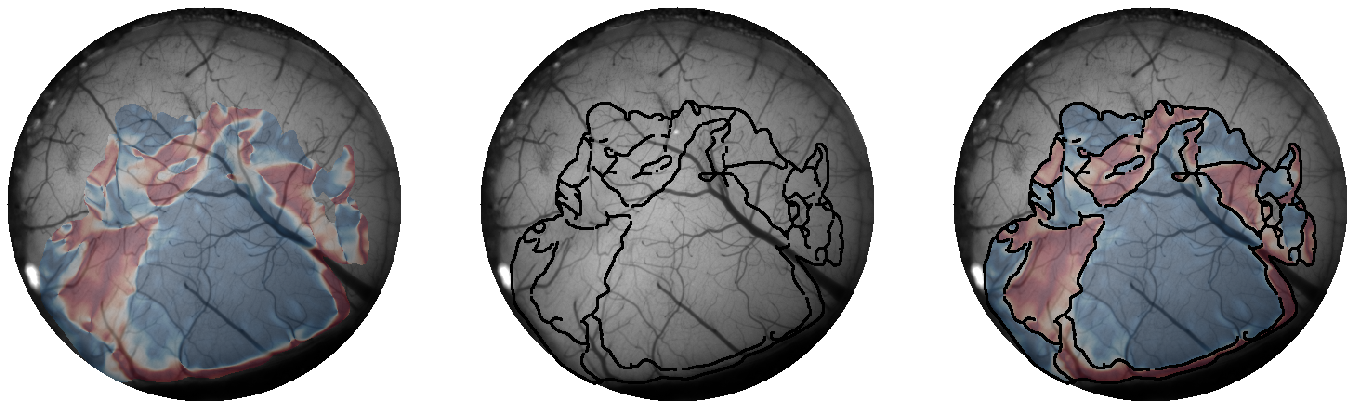

In [4]:
# Detect outer edges of sign map
signmap_threshold = signmap.copy()
kernel_edge = np.array([[-1, -1, -1],
                        [-1, 1, -1],
                        [-1, -1 , -1]])
for row in np.arange(1, signmap_threshold.shape[0] - 1):
    for col in np.arange(1, signmap_threshold.shape[1] - 1):
        curr_idx = np.ix_((row - 1, row, row + 1),(col - 1, col, col + 1))
        if not (np.isnan(signmap[row,col]) and
                    np.isnan(np.tensordot(kernel_edge, signmap_threshold[curr_idx], axes=((0,1),(0,1))))):
            signmap_threshold[curr_idx] = 0

# Threshold sign map around 0 to detect visual area boundaries
np.add.at(signmap_threshold, np.logical_or(signmap < -0.35, signmap > 0.35), np.nan)

# Skeletonize, then dilate thresholded sign map
from skimage.morphology import skeletonize
import cv2
signmap_skeleton = skeletonize(~np.isnan(signmap_threshold))
kernel_dilate = np.ones((3, 3), np.uint8)
signmap_outline = cv2.dilate(signmap_skeleton.astype('float'), kernel_dilate, iterations=1)
signmap_outline[signmap_outline == 0] = np.nan

# Plot sign map, visual area boundaries, and merge
%matplotlib inline
fig, axs = plt.subplots(1,3)
axs[0].imshow(ref_frame, cmap='gray')
axs[0].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[0].axis('off')
axs[1].imshow(ref_frame, cmap='gray')
axs[1].imshow(signmap_outline, cmap='Greys', clim=[0,1], alpha=1)
axs[1].axis('off')
axs[2].imshow(ref_frame, cmap='gray')
axs[2].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[2].imshow(signmap_outline, cmap='Greys', clim=[0,1], alpha=1)
axs[2].axis('off')
fig.set_size_inches(24, 8)

Generate Matrix of Window Means and Window Indices

In [5]:
# Get mean of windows and reshape data into matrix
window_idx = np.arange(dFF_masked.shape[1]).reshape(int(dFF_masked.shape[1]/window_size), window_size)
window_mat = []
window_idx_mat = np.zeros((window_idx.shape[0]**2,4))
for row_seed in range(int(dFF_masked.shape[1]/window_size)):
    for col_seed in range(int(dFF_masked.shape[2]/window_size)):
        curr_window = np.concatenate((window_idx[row_seed,:], window_idx[col_seed,:]))
        window_mean = dFF_masked[np.ix_(range(dFF_masked.shape[0]),curr_window[[0,1]],curr_window[[2,3]])].mean(axis=(1,2))
        window_mat.append(window_mean)
        window_idx_mat[len(window_mat)-1] = curr_window
window_mat = np.asarray(window_mat)

Display GUI for Interacting with SCA Maps

In [36]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

%matplotlib qt5
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.axis('off')
fig.set_size_inches(8, 8)

def on_move(event):
    if event.inaxes:
        ax = event.inaxes
        ax.clear()
        ax.imshow(ref_frame, cmap='gray')
        curr_coors = np.round([event.ydata, event.xdata])
        curr_seed = np.where(np.sum((window_idx_mat[:,[0,1]] == curr_coors[0]) + (window_idx_mat[:,[2,3]] == curr_coors[1]), axis=1) == 2)[0][0]
        def calc_corr(s,v):
            PCC = np.corrcoef(window_mat[s,:],window_mat[v,:])[1,0]
            return PCC
        corr_mat = np.zeros((dFF_masked.shape[1], dFF_masked.shape[2]))
        corr_list = Parallel(n_jobs=6)(delayed(calc_corr)(curr_seed,v) for v in range(window_mat.shape[0]))
        for loc in range(len(corr_list)):
            corr_mat[np.ix_(window_idx_mat[loc][[0,1]].astype('int'),window_idx_mat[loc][[2,3]].astype('int'))] = np.tile(corr_list[loc],(window_size,window_size))
        ax.imshow(corr_mat, cmap='RdBu_r', clim=[0.8,1.0], alpha=0.5)
        ax.scatter(event.xdata, event.ydata, color='k')
        ax.axis('off')
        fig.set_size_inches(8, 8)
        plt.draw()

def on_click(event):
    if event.button is MouseButton.LEFT:
        plt.disconnect(binding_id)

binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

9

Traceback (most recent call last):
  File "/Users/ryan.gorzek/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_17551/1063923595.py", line 21, in on_move
    curr_seed = np.where(np.sum((window_idx_mat[:,[0,1]] == curr_coors[0]) + (window_idx_mat[:,[2,3]] == curr_coors[1]), axis=1) == 2)[0][0]
IndexError: index 0 is out of bounds for axis 0 with size 0
